<a href="https://colab.research.google.com/github/axiao23/BryanRanger--Enhancing-Newborn-Health-Assessment/blob/main/HOG_and_SIFT_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HOG Regression & SIFT Regression**
The following colab notebook details the entire Data loading and architecture of HOG and SIFT Regression techniques which are used in comparison to deep-learning models like UNet.

## Data-Loading for HOG and SIFT

Data-loading for HOG and SIFT is almost identical to that of UNet and is detailed below. It can be noted that the data is connected to a path in Google Drive which is not provided here. The first segment in the UNet code provides the details to this section.

45
13


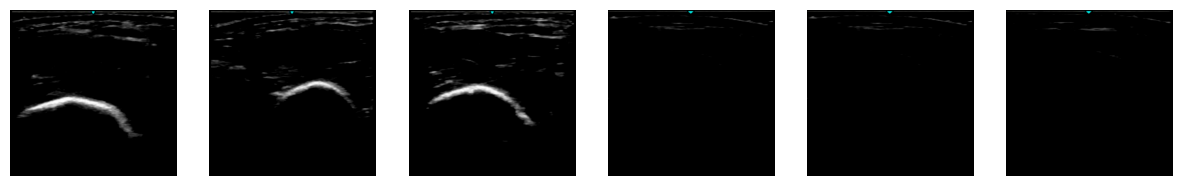

tensor([1.5033], dtype=torch.float64)
tensor([1.5575], dtype=torch.float64)
tensor([39.8000], dtype=torch.float64)
✅ Patient 0 loaded successfully
✅ Patient 1 loaded successfully
✅ Patient 2 loaded successfully
✅ Patient 3 loaded successfully
✅ Patient 4 loaded successfully
✅ Patient 5 loaded successfully
✅ Patient 6 loaded successfully
✅ Patient 7 loaded successfully
✅ Patient 8 loaded successfully
✅ Patient 9 loaded successfully
✅ Patient 10 loaded successfully
✅ Patient 11 loaded successfully
✅ Patient 12 loaded successfully


In [ ]:
normalization_factors = 0.5
tx_X = transforms.Compose([transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(normalization_factors, normalization_factors)])
REGION = "BQ" #B, A, Q, BA,BQ, AQ, BAQ
OUTPUT = "FFM" #FFM
AUGMENT = 0 #0, 5, 8, 15
SPECKLE = False #Medianfilter
dataset = PatientDataset(transform = tx_X,
                 augmented_dataset = False,
                 augment = AUGMENT,
                 threshold = False,
                 speckle = SPECKLE,
                 despeckle = False,
                 region_combination = REGION,
                 number_of_image = 3, #1, 2, 3
                 crop = [1, 1, 1], #
                 output = OUTPUT)

## Only if we are augmenting the entire dataset rather than individual image
# augmented_dataset = AugmentedPatientDataset(dataset, transform = tx_X)
# train_size = int(0.8 * len(augmented_dataset))
# test_size = len(augmented_dataset) - train_size
# train_dataset, test_dataset = random_split(augmented_dataset, [train_size, test_size])

#train_size = int(0.7 * len(dataset))  # 70% for training
train_size = 45 # hardcoded for 70:20:10 = 45:13:7
test_size = len(dataset) - train_size  # Remaining 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
print(len(train_loader))
print(len(test_loader))# Show if we load the image successfully
for i in range(1):
  first_batch = next(iter(train_loader))
  first_batch_images = first_batch[0]
  first_batch_label = first_batch[1]
  first_batch_W = first_batch[2]
  first_batch_L = first_batch[3]
  fig, axs = plt.subplots(1, len(first_batch_images), figsize=(15, 5))
  for i in range(len(first_batch_images)):
      img = im_converterX(first_batch_images[i][0])
      axs[i].imshow(img)
      axs[i].axis('off')
  plt.show()
  print(first_batch_label)
  print(first_batch_W)
  print(first_batch_L)
  for i in range(len(test_dataset)):
    try:
        data = test_dataset[i]
        print(f"✅ Patient {i} loaded successfully")
    except Exception as e:
        print(f"❌ Patient {i} failed: {e}")

## HOG Regression

The following code extracts HOG features from the images.

HOG regression is the use of Histogram of Oriented Gradients (HOG) features as the input for a regression model. A HOG feature vector describes the local shape and appearance of an object in an image by capturing the distribution of intensity gradients and edge directions. A regression model is a machine learning algorithm used to predict a continuous numerical value.

In [ ]:
import numpy as np
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def tensor_to_np_img(tensor_img):
    # tensor shape: (3, 256, 256), convert to (256, 256, 3) #due to how the HOG model takes inputs
    return np.transpose(tensor_img.cpu().numpy(), (1, 2, 0))

def extract_features_and_labels(dataloader):
    features = []
    labels = []
    for images, target, *_ in dataloader:
        hog_features = []
        for img_tensor in images:
            img_np = tensor_to_np_img(img_tensor[0])  # remove batch dimension
            gray = rgb2gray(img_np)
            feat = hog(gray, orientations=9, pixels_per_cell=(8, 8), #feature extraction method using HOG
                       cells_per_block=(2, 2), block_norm='L2-Hys',
                       feature_vector=True)
            hog_features.append(feat)
        avg_feat = np.mean(hog_features, axis=0)
        features.append(avg_feat)
        labels.append(target.item())
    return np.array(features), np.array(labels)

In [ ]:
# Tracking the training and testing features and labels from our data
X_train_hog, y_train_hog = extract_features_and_labels(train_loader)
X_test_hog, y_test_hog = extract_features_and_labels(test_loader)

In [ ]:
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np

# Example: Extract HOG features from a single image (expects shape: H x W x 3)
def extract_hog_features(image):
    gray_image = rgb2gray(image)  # HOG expects grayscale
    features = hog(gray_image,
                   orientations=9,# does this number change depending on the region combination?
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys',
                   feature_vector=True)
    return features

# Assume each sample has multiple images (e.g., 6 images per infant)
def aggregate_features(image_list):
    hog_features = [extract_hog_features(img) for img in image_list]
    return np.mean(hog_features, axis=0)  # Average across body parts

# X: list of image_lists (i.e., list of [img1, img2, ..., img6])
# y: list of target values (FM)
def train_hog_regressor(X, y, model_type='random_forest'):
    X_features = [aggregate_features(img_list) for img_list in X]

    if model_type == 'random_forest':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == 'linear':
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ])
    else:
        raise ValueError("Unsupported model_type")

    model.fit(X_features, y)
    return model

In [ ]:
# Using HOG to predict our body composition metrics
from sklearn.ensemble import RandomForestRegressor

hog_model = RandomForestRegressor(n_estimators=100, random_state=42)
hog_model.fit(X_train_hog, y_train_hog)

y_pred = hog_model.predict(X_test_hog)

The following cell generates statistics for HOG regression. These statistical functions are defined in our UNet code file.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    # Avoid division by zero
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

# Predictions
y_pred = hog_model.predict(X_test_hog)

# Metrics
mae = mean_absolute_error(y_test_hog, y_pred)
mse = mean_squared_error(y_test_hog, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_hog, y_pred)

# Print all
print(f"📊 MAE:  {mae:.4f}")
print(f"📊 MSE:  {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")

📊 MAE:  0.2902
📊 MSE:  0.1213
📊 RMSE: 0.3483
📊 MAPE: 14.44%


In [ ]:
#printing and displaying the ground truth and the prediction values
GT_FM = y_test_hog
Pred_FM = y_pred
print(GT_FM)
print(Pred_FM)

[1.5941 1.5864 2.2142 2.8285 1.5766 2.0062 2.1826 2.1828 2.3065 2.2386
 1.7668 1.6738 2.0811]
[1.983429 1.990467 1.849891 1.975233 1.898209 1.900978 2.063347 2.019576
 2.055515 1.9426   1.961083 1.898257 1.994847]


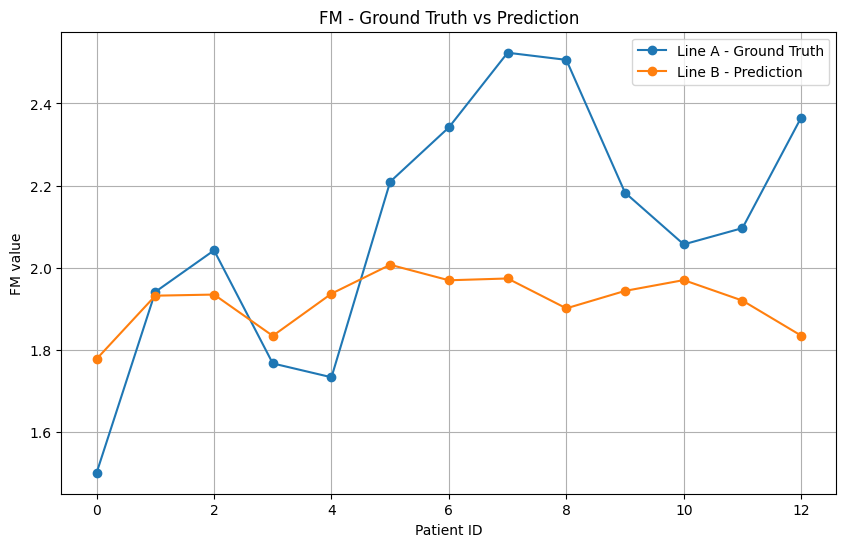

In [ ]:
# Visualization of HOG results
import matplotlib.pyplot as plt

# Make sure y_test_hog and y_pred are NumPy arrays
GT_FM = y_test_hog
Pred_FM = y_pred

plt.figure(figsize=(10, 6))
plt.plot(GT_FM, label='Line A - Ground Truth', marker='o')
plt.plot(Pred_FM, label='Line B - Prediction', marker='o')
plt.xlabel('Patient ID')
plt.ylabel('FM value')
plt.legend()
plt.title('FM - Ground Truth vs Prediction')
plt.grid(True)
plt.show()

## SIFT Regression

The following code uses SIFT to extract descriptors. Next, it applies KMeans to cluster descriptors. Then, the code represent each image as a histogram of visual words (BoVW). It finds the average histograms across images per patient and finally train a regression model on those histograms.

In [ ]:
# Importing dependencies and extracting descriptors
import cv2
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

sift = cv2.SIFT_create()

def extract_sift_descriptors(images):
    descriptors_list = []
    for img_tensor in images:
        img_np = tensor_to_np_img(img_tensor[0])
        gray = cv2.cvtColor((img_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list

In [ ]:
# Gather all descriptors from the training set to fit KMeans
all_descriptors = []
for images, _, *_ in tqdm(train_loader):
    desc = extract_sift_descriptors(images)
    for d in desc:
        all_descriptors.append(d)
all_descriptors = np.vstack(all_descriptors)

# Use MiniBatchKMeans for efficiency (e.g., 100 clusters)
k = 100
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1000)
kmeans.fit(all_descriptors)

100%|██████████| 45/45 [00:05<00:00,  7.61it/s]


MiniBatchKMeans(batch_size=1000, n_clusters=100, random_state=42)

In [ ]:
# Computing of the BovW histograms from images
def compute_bovw_histogram(descriptors, kmeans, k):
    histogram = np.zeros(k)
    if descriptors is not None and len(descriptors) > 0:
        cluster_assignments = kmeans.predict(descriptors)
        for idx in cluster_assignments:
            histogram[idx] += 1
    return histogram

In [ ]:
# Feature Extraction
def extract_bovw_features(dataloader, kmeans, k):
    features = []
    labels = []
    for images, target, *_ in dataloader:
        desc_list = extract_sift_descriptors(images)
        hists = [compute_bovw_histogram(desc, kmeans, k) for desc in desc_list]
        avg_hist = np.mean(hists, axis=0)
        features.append(avg_hist)
        labels.append(target.item())
    return np.array(features), np.array(labels)

X_train_sift, y_train_sift = extract_bovw_features(train_loader, kmeans, k)
X_test_sift, y_test_sift = extract_bovw_features(test_loader, kmeans, k)

The cell below takes the SIFT model and generates metrics for body composition prediction. It can be used after data-loading.

In [ ]:

from sklearn.ensemble import RandomForestRegressor

sift_model = RandomForestRegressor(n_estimators=100, random_state=42)
sift_model.fit(X_train_sift, y_train_sift)

y_pred_sift = sift_model.predict(X_test_sift)

# Metrics
mae = mean_absolute_error(y_test_sift, y_pred_sift)
mse = mean_squared_error(y_test_sift, y_pred_sift)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test_sift, y_pred_sift)

print(f"📊 MAE:  {mae:.4f}")
print(f"📊 MSE:  {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")

📊 MAE:  0.2864
📊 MSE:  0.1178
📊 RMSE: 0.3432
📊 MAPE: 14.16%


In [ ]:
#printing and displaying the ground truth and the prediction values
GT_FM = y_test_sift
Pred_FM = y_pred_sift
print(GT_FM)
print(Pred_FM)

[1.5864 1.6738 1.5766 2.0062 2.1828 2.3065 1.5941 2.8285 2.2386 2.0811
 1.7668 2.2142 2.1826]
[1.79596  2.009218 1.964552 1.992067 1.820428 2.148336 1.956607 2.011541
 1.948254 1.948739 1.890959 1.873407 1.994055]


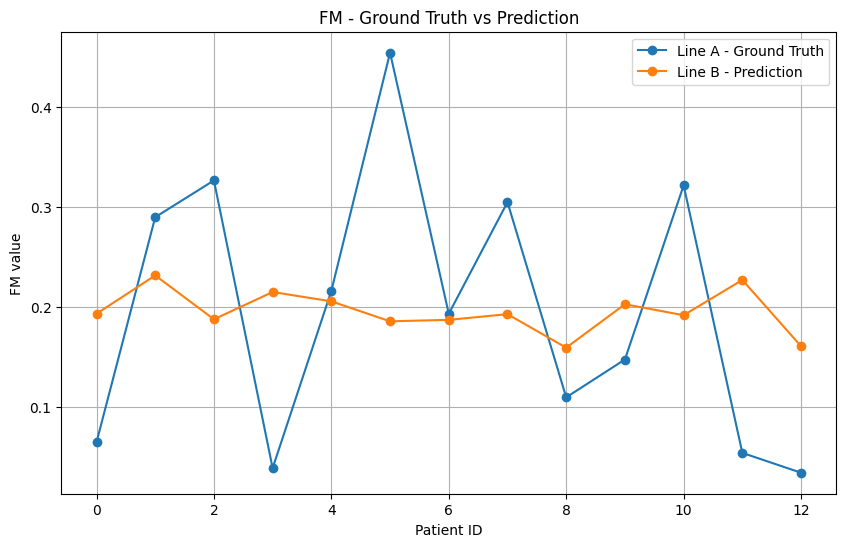

In [ ]:
# Visualization of SIFT results
import matplotlib.pyplot as plt

# Make sure y_test_hog and y_pred are NumPy arrays
GT_FM = y_test_sift
Pred_FM = y_pred_sift

plt.figure(figsize=(10, 6))
plt.plot(GT_FM, label='Line A - Ground Truth', marker='o')
plt.plot(Pred_FM, label='Line B - Prediction', marker='o')
plt.xlabel('Patient ID')
plt.ylabel('FM value')
plt.legend()
plt.title('FM - Ground Truth vs Prediction')
plt.grid(True)
plt.show()

In [ ]:
print(GT_FM)
print(Pred_FM)


[0.1704 0.4044 0.1677 0.3361 0.2896 0.1792 0.1466 0.0808 0.0832 0.2073
 0.0911 0.1409 0.0824]
[0.242677 0.209867 0.22428  0.223653 0.206642 0.211063 0.228272 0.206888
 0.201027 0.185523 0.194158 0.230402 0.185035]


## Training of HOG and SIFT

The Training of HOG and SIFT can be done similarly to UNet- See the masterfile for training code and loading models.

In [ ]:
CRITERION = "MAE" # other options include MAE, MAPE, MSE, Custom
WL = False # Weight+Length
EPOCHS = 40
LR = 0.001 #0.001 for unet, 0.0005 for attUNet
ADAPTIVE = True
train_history, validation_history = training(EPOCHS, CRITERION, LR, model, MODEL, ADAPTIVE, WL)

[Train] Epoch 1, Batch 0, y_pred: [-0.00037979], y_train: [0.059]
[Train] Epoch 1, Batch 10, y_pred: [0.22969504], y_train: [0.2838]
[Train] Epoch 1, Batch 20, y_pred: [0.076529], y_train: [0.0426]
[Train] Epoch 1, Batch 30, y_pred: [0.2994839], y_train: [0.2659]
[Train] Epoch 1, Batch 40, y_pred: [0.08634774], y_train: [0.0824]
[Train] Epoch 1, Batch 50, y_pred: [0.33578032], y_train: [0.3481]
Epoch 1 completed
Average train loss: 0.1363
Average validation loss: 0.1937
✔️  Saved new best model
[Train] Epoch 2, Batch 0, y_pred: [0.38501194], y_train: [0.3263]
[Train] Epoch 2, Batch 10, y_pred: [0.13716346], y_train: [0.3046]
[Train] Epoch 2, Batch 20, y_pred: [0.19560893], y_train: [0.0426]
[Train] Epoch 2, Batch 30, y_pred: [0.11148387], y_train: [0.2838]
[Train] Epoch 2, Batch 40, y_pred: [0.18333744], y_train: [0.3361]
[Train] Epoch 2, Batch 50, y_pred: [0.00737403], y_train: [0.0648]
Epoch 2 completed
Average train loss: 0.1160
Average validation loss: 0.1807
✔️  Saved new best mod